In [54]:
# -*- coding: cp1251 -*-
from DEVS import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

maxAngents = 100
arrivalRateMin = 1
arrivalRateMax = 8
service_xk = np.arange(13, 19) + 1
service_pk = (0.1, 0.2, 0.3, 0.25, 0.1, 0.05)
seed = 42
custm = stats.rv_discrete(name="custm", values=(service_xk, service_pk), seed = seed)

avg_queue_time = {}
total_time = {}
waited_custs = {}
server_dynamic = {}

In [55]:
# QUEUE TYPE: General queue
queue_type = "General queue"

custm = stats.rv_discrete(name="custm", values=(service_xk, service_pk), seed = seed)

# ---- Customer Statistics ----
class customerStat:
    def __init__(self):
        self.id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0


# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if len(DEVS.stats) > 0:
            customer.interArrivalTime = (
                customer.arrivalTime - DEVS.stats[-1].arrivalTime
            )

        print("Time %d" % self.eTime, " Arrival Event of agent {0}".format(customer.id))
        if DEVS.newId < maxAngents - 1:
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime + random.randint(
                arrivalRateMin, arrivalRateMax
            )
            DEVS.EQ.AddEvent(NextArrival)

        server = -1
        # Server choosing policy
        for i in range(len(DEVS.serverIdle)):
            if DEVS.serverIdle[i] == True:
                server = i
                break

        # server is Free
        if server != -1:
            DEVS.serverIdle[server] = False
            print("server %d is Busy" % server)
            Service = ServiceEvent(server)
            serviceTime = custm.rvs()
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime  # current time
            Service.eTime = self.eTime + serviceTime
            Service.id = customer.id
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            # increase waiting line
            DEVS.customerQueue.append(customer.id)
            print("customerQueue = %d" % len(DEVS.customerQueue))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


# ---- Service (END) Event ----
class ServiceEvent:
    def __init__(self, n):
        self.eTime = 0.0
        self.number = n
        self.id = 0

    def Execute(self):
        ind = [i for i, val in enumerate(DEVS.stats) if val.id == self.id][0]
        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = (
            DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime
        )
        DEVS.stats[ind].waitingTimeInQueue = (
            DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime
        )  # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = (
            DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        )

        print(
            "Time %d" % self.eTime,
            "Server %d service finished" % self.number,
        )
        if len(DEVS.customerQueue) > 0:
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i, val in enumerate(DEVS.stats) if val.id == qid][0]
            Service = ServiceEvent(self.number)
            serviceTime = custm.rvs()
            Service.eTime = self.eTime + serviceTime
            Service.id = qid
            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime
            DEVS.EQ.AddEvent(Service)
            print("take new customer from the queue")
        else:
            DEVS.serverIdle[self.number] = True
            print("server %d is Idle (do nothing)" % self.number)

        DEVS.lastServedTime = self.eTime


# run simulation
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)

number_of_servers = 4
# simulation attributes
DEVS.customerQueue = []
DEVS.stats = []
DEVS.newId = 0
DEVS.serverIdle = [True for i in range(number_of_servers)]
DEVS.lastServedTime = 0  # for Idle time

# --- SIMULATION ---
while DEVS.EQ.QueueSize() > 0:
    DEVS.ProcessNextEvent()

# --- STATISTICS ---

#  --- store all in file  ---
f = open("output.csv", "w")
f.write(
    "Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n"
)
for s in DEVS.stats:
    f.write(
        "{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(
            s.id,
            s.interArrivalTime,
            s.arrivalTime,
            s.serviceTime,
            s.serviceBegins,
            s.waitingTimeInQueue,
            s.serviceEnds,
            s.timeInSystem,
            s.idleTimeOfServer,
        )
    )
f.close()

# 1) Average waiting time in queue
avTimeInQueue = sum([x.waitingTimeInQueue for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

# 2) Probability that a customer has to wait
probToWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0]) / len(DEVS.stats)
print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

# 3) Probability of an Idle server
probIdle = sum([x.idleTimeOfServer for x in DEVS.stats]) / DEVS.GlobalTime
print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

# 4) Average service time (theoretical 3.2)
avServiceTime = sum([x.serviceTime for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage service time: {0:.2f}".format(avServiceTime))

# 5) Average time between arrivals (theoretical 4.5)
avTimeBetwArr = sum([x.interArrivalTime for x in DEVS.stats]) / (len(DEVS.stats) - 1)
print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

# 6) Average waiting time for those who wait
numOfCustWhoWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0])
avTimeWhoWait = sum([x.waitingTimeInQueue for x in DEVS.stats]) / numOfCustWhoWait
print("\nAverage waiting time for those who wait: {0:.2f}".format(avTimeWhoWait))

# 7) Average time a customer spends in the system
avTimeInTheSystem1 = sum([x.timeInSystem for x in DEVS.stats]) / len(DEVS.stats)
print(
    "\nAverage time a customer spends in the system: {0:.2f}".format(avTimeInTheSystem1)
)

avTimeInTheSystem2 = avTimeInQueue + avServiceTime
print(
    "\nAverage time a customer spends in the system (alternative): {0:.2f}".format(
        avTimeInTheSystem2
    )
)


total_time[queue_type] = DEVS.lastServedTime
avg_queue_time[queue_type] = avTimeInQueue
waited_custs[queue_type] = numOfCustWhoWait

Time 0  Arrival Event of agent 0
server 0 is Busy
Time 2  Arrival Event of agent 1
server 1 is Busy
Time 4  Arrival Event of agent 2
server 2 is Busy
Time 6  Arrival Event of agent 3
server 3 is Busy
Time 8  Arrival Event of agent 4
customerQueue = 1
Time 13  Arrival Event of agent 5
customerQueue = 2
Time 16 Server 0 service finished
take new customer from the queue
Time 21 Server 1 service finished
take new customer from the queue
Time 21 Server 2 service finished
server 2 is Idle (do nothing)
Time 21  Arrival Event of agent 6
server 2 is Busy
Time 22 Server 3 service finished
server 3 is Idle (do nothing)
Time 26  Arrival Event of agent 7
server 3 is Busy
Time 31 Server 0 service finished
server 0 is Idle (do nothing)
Time 33  Arrival Event of agent 8
server 0 is Busy
Time 35 Server 2 service finished
server 2 is Idle (do nothing)
Time 36 Server 1 service finished
server 1 is Idle (do nothing)
Time 38  Arrival Event of agent 9
server 1 is Busy
Time 43  Arrival Event of agent 10
serv

In [56]:
# QUEUE TYPE: Shortest queue
queue_type = "Shortest queue"

custm = stats.rv_discrete(name="custm", values=(service_xk, service_pk), seed = seed)
# ---- Customer Statistics ----
class customerStat:
    def __init__(self):
        self.id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0


# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if len(DEVS.stats) > 0:
            customer.interArrivalTime = (
                customer.arrivalTime - DEVS.stats[-1].arrivalTime
            )

        print("Time %d" % self.eTime, " Arrival Event of agent {0}".format(customer.id))
        if DEVS.newId < maxAngents - 1:
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime + random.randint(
                arrivalRateMin, arrivalRateMax
            )
            DEVS.EQ.AddEvent(NextArrival)

        server = -1
        # Server choosing policy
        server = DEVS.serverQueue.index(min(DEVS.serverQueue, key=len))

        print("server %d add element to local queue" % server)

        Service = ServiceEvent(server)
        serviceTime = custm.rvs()
        customer.serviceTime = serviceTime
        # Time when last event ended
        customer.serviceBegins = (
            DEVS.serverQueue[server][-1] if DEVS.serverQueue[server] else self.eTime
        )
        Service.eTime = self.eTime + serviceTime

        # Append event ending time to queue
        DEVS.serverQueue[server].append(Service.eTime)

        Service.id = customer.id
        DEVS.EQ.AddEvent(Service)

        # server is Busy is not an option - all customers divided into server queues
        # else:
        #     # increase waiting line
        #     DEVS.customerQueue.append(customer.id)
        #     print("customerQueue = %d" % len(DEVS.customerQueue))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


# ---- Service (END) Event ----
class ServiceEvent:
    def __init__(self, n):
        self.eTime = 0.0
        self.number = n
        self.id = 0

    def Execute(self):
        ind = [i for i, val in enumerate(DEVS.stats) if val.id == self.id][0]
        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = (
            DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime
        )
        DEVS.stats[ind].waitingTimeInQueue = (
            DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime
        )  # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = (
            DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        )

        print(
            "Time %d" % self.eTime,
            "Server %d service finished" % self.number,
        )
        if len(DEVS.customerQueue) > 0:
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i, val in enumerate(DEVS.stats) if val.id == qid][0]
            Service = ServiceEvent(self.number)
            serviceTime = custm.rvs()
            Service.eTime = self.eTime + serviceTime
            Service.id = qid
            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime
            DEVS.EQ.AddEvent(Service)
            print("take new customer from the queue")
        else:
            DEVS.serverIdle[self.number] = True
            DEVS.serverQueue[self.number].pop(0)
            print(
                "server %d queue is %d"
                % (self.number, len(DEVS.serverQueue[self.number]))
            )

        DEVS.lastServedTime = self.eTime


# run simulation
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)

number_of_servers = 4
# simulation attributes
DEVS.customerQueue = []
DEVS.stats = []
DEVS.newId = 0
DEVS.serverIdle = [True for i in range(number_of_servers)]
DEVS.lastServedTime = 0  # for Idle time
DEVS.serverQueue = [[] for i in range(number_of_servers)]

# --- SIMULATION ---
while DEVS.EQ.QueueSize() > 0:
    DEVS.ProcessNextEvent()

# --- STATISTICS ---

#  --- store all in file  ---
f = open("output.csv", "w")
f.write(
    "Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n"
)
for s in DEVS.stats:
    f.write(
        "{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(
            s.id,
            s.interArrivalTime,
            s.arrivalTime,
            s.serviceTime,
            s.serviceBegins,
            s.waitingTimeInQueue,
            s.serviceEnds,
            s.timeInSystem,
            s.idleTimeOfServer,
        )
    )
f.close()

# 1) Average waiting time in queue
avTimeInQueue = sum([x.waitingTimeInQueue for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

# 2) Probability that a customer has to wait
probToWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0]) / len(DEVS.stats)
print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

# 3) Probability of an Idle server
probIdle = sum([x.idleTimeOfServer for x in DEVS.stats]) / DEVS.GlobalTime
print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

# 4) Average service time (theoretical 3.2)
avServiceTime = sum([x.serviceTime for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage service time: {0:.2f}".format(avServiceTime))

# 5) Average time between arrivals (theoretical 4.5)
avTimeBetwArr = sum([x.interArrivalTime for x in DEVS.stats]) / (len(DEVS.stats) - 1)
print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

# 6) Average waiting time for those who wait
numOfCustWhoWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0])
avTimeWhoWait = sum([x.waitingTimeInQueue for x in DEVS.stats]) / numOfCustWhoWait
print("\nAverage waiting time for those who wait: {0:.2f}".format(avTimeWhoWait))

# 7) Average time a customer spends in the system
avTimeInTheSystem1 = sum([x.timeInSystem for x in DEVS.stats]) / len(DEVS.stats)
print(
    "\nAverage time a customer spends in the system: {0:.2f}".format(avTimeInTheSystem1)
)

avTimeInTheSystem2 = avTimeInQueue + avServiceTime
print(
    "\nAverage time a customer spends in the system (alternative): {0:.2f}".format(
        avTimeInTheSystem2
    )
)

total_time[queue_type] = DEVS.lastServedTime
avg_queue_time[queue_type] = avTimeInQueue
waited_custs[queue_type] = numOfCustWhoWait


Time 0  Arrival Event of agent 0
server 0 add element to local queue
Time 2  Arrival Event of agent 1
server 1 add element to local queue
Time 8  Arrival Event of agent 2
server 2 add element to local queue
Time 9  Arrival Event of agent 3
server 3 add element to local queue
Time 11  Arrival Event of agent 4
server 0 add element to local queue
Time 16 Server 0 service finished
server 0 queue is 1
Time 17  Arrival Event of agent 5
server 0 add element to local queue
Time 21 Server 1 service finished
server 1 queue is 0
Time 23  Arrival Event of agent 6
server 1 add element to local queue
Time 24  Arrival Event of agent 7
server 1 add element to local queue
Time 25 Server 2 service finished
server 2 queue is 0
Time 25 Server 3 service finished
server 3 queue is 0
Time 26 Server 0 service finished
server 0 queue is 1
Time 29  Arrival Event of agent 8
server 2 add element to local queue
Time 31  Arrival Event of agent 9
server 3 add element to local queue
Time 32 Server 0 service finished


In [57]:
# QUEUE TYPE: Dynamic general queue
queue_type = "Dynamic g queue"

server_dynamic[queue_type] = []

custm = stats.rv_discrete(name="custm", values=(service_xk, service_pk), seed = seed)
# ---- Customer Statistics ----
class customerStat:
    def __init__(self):
        self.id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0


# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if len(DEVS.stats) > 0:
            customer.interArrivalTime = (
                customer.arrivalTime - DEVS.stats[-1].arrivalTime
            )

        print("Time %d" % self.eTime, " Arrival Event of agent {0}".format(customer.id))
        if DEVS.newId < maxAngents - 1:
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime + random.randint(
                arrivalRateMin, arrivalRateMax
            )
            DEVS.EQ.AddEvent(NextArrival)

        server = -1
        # Server choosing policy
        free_servers = len([item for item in DEVS.serverIdle if item == True])

        if (free_servers == 0) and (DEVS.extended == False):
            server = 4
            DEVS.extended = True
        elif (free_servers >= 2) and (DEVS.extended == True):
            DEVS.extended = False
            for i in range(len(DEVS.serverIdle) - 1):
                if DEVS.serverIdle[i] == True:
                    server = i
                    break
        else:
            for i in range(len(DEVS.serverIdle)):
                if DEVS.serverIdle[i] == True:
                    server = i
                    break

        # server is Free
        if server != -1:
            DEVS.serverIdle[server] = False
            print("server %d is Busy" % server)
            Service = ServiceEvent(server)
            serviceTime = custm.rvs()
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime  # current time
            Service.eTime = self.eTime + serviceTime
            Service.id = customer.id
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            # increase waiting line
            DEVS.customerQueue.append(customer.id)
            print("customerQueue = %d" % len(DEVS.customerQueue))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


# ---- Service (END) Event ----
class ServiceEvent:
    def __init__(self, n):
        self.eTime = 0.0
        self.number = n
        self.id = 0

    def Execute(self):
        ind = [i for i, val in enumerate(DEVS.stats) if val.id == self.id][0]
        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = (
            DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime
        )
        DEVS.stats[ind].waitingTimeInQueue = (
            DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime
        )  # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = (
            DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        )

        print(
            "Time %d" % self.eTime,
            "Server %d service finished" % self.number,
        )
        if len(DEVS.customerQueue) > 0:
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i, val in enumerate(DEVS.stats) if val.id == qid][0]
            Service = ServiceEvent(self.number)
            serviceTime = custm.rvs()
            Service.eTime = self.eTime + serviceTime
            Service.id = qid
            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime
            DEVS.EQ.AddEvent(Service)
            print("take new customer from the queue")
        else:
            DEVS.serverIdle[self.number] = True
            print("server %d is Idle (do nothing)" % self.number)

        DEVS.lastServedTime = self.eTime
        
        working_servers = len([item for item in DEVS.serverIdle[:-1] if item == False])
        if (DEVS.extended == True) and (DEVS.serverIdle[-1] == False):
            working_servers += 1

        server_dynamic[queue_type].append((DEVS.lastServedTime, working_servers))



# run simulation
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)

number_of_servers = 4
# simulation attributes
DEVS.customerQueue = []
DEVS.stats = []
DEVS.newId = 0
DEVS.serverIdle = [True for i in range(number_of_servers + 1)]
DEVS.extended = False
DEVS.lastServedTime = 0  # for Idle time

# --- SIMULATION ---
while DEVS.EQ.QueueSize() > 0:
    DEVS.ProcessNextEvent()

# --- STATISTICS ---

#  --- store all in file  ---
f = open("output.csv", "w")
f.write(
    "Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n"
)
for s in DEVS.stats:
    f.write(
        "{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(
            s.id,
            s.interArrivalTime,
            s.arrivalTime,
            s.serviceTime,
            s.serviceBegins,
            s.waitingTimeInQueue,
            s.serviceEnds,
            s.timeInSystem,
            s.idleTimeOfServer,
        )
    )
f.close()

# 1) Average waiting time in queue
avTimeInQueue = sum([x.waitingTimeInQueue for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

# 2) Probability that a customer has to wait
probToWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0]) / len(DEVS.stats)
print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

# 3) Probability of an Idle server
probIdle = sum([x.idleTimeOfServer for x in DEVS.stats]) / DEVS.GlobalTime
print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

# 4) Average service time (theoretical 3.2)
avServiceTime = sum([x.serviceTime for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage service time: {0:.2f}".format(avServiceTime))

# 5) Average time between arrivals (theoretical 4.5)
avTimeBetwArr = sum([x.interArrivalTime for x in DEVS.stats]) / (len(DEVS.stats) - 1)
print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

# 6) Average waiting time for those who wait
numOfCustWhoWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0])
avTimeWhoWait = sum([x.waitingTimeInQueue for x in DEVS.stats]) / numOfCustWhoWait
print("\nAverage waiting time for those who wait: {0:.2f}".format(avTimeWhoWait))

# 7) Average time a customer spends in the system
avTimeInTheSystem1 = sum([x.timeInSystem for x in DEVS.stats]) / len(DEVS.stats)
print(
    "\nAverage time a customer spends in the system: {0:.2f}".format(avTimeInTheSystem1)
)

avTimeInTheSystem2 = avTimeInQueue + avServiceTime
print(
    "\nAverage time a customer spends in the system (alternative): {0:.2f}".format(
        avTimeInTheSystem2
    )
)

total_time[queue_type] = DEVS.lastServedTime
avg_queue_time[queue_type] = avTimeInQueue
waited_custs[queue_type] = numOfCustWhoWait


Time 0  Arrival Event of agent 0
server 0 is Busy
Time 1  Arrival Event of agent 1
server 1 is Busy
Time 8  Arrival Event of agent 2
server 2 is Busy
Time 14  Arrival Event of agent 3
server 3 is Busy
Time 16 Server 0 service finished
server 0 is Idle (do nothing)
Time 18  Arrival Event of agent 4
server 0 is Busy
Time 19  Arrival Event of agent 5
server 4 is Busy
Time 20 Server 1 service finished
server 1 is Idle (do nothing)
Time 20  Arrival Event of agent 6
server 1 is Busy
Time 21  Arrival Event of agent 7
server 4 is Busy
Time 22  Arrival Event of agent 8
customerQueue = 1
Time 25 Server 2 service finished
take new customer from the queue
Time 26  Arrival Event of agent 9
customerQueue = 1
Time 28  Arrival Event of agent 10
customerQueue = 2
Time 30 Server 3 service finished
take new customer from the queue
Time 30  Arrival Event of agent 11
customerQueue = 2
Time 33 Server 0 service finished
take new customer from the queue
Time 34 Server 4 service finished
take new customer from

In [58]:


# QUEUE TYPE: Dynamic Shortest queue

queue_type = "Dynamic Shortest"

server_dynamic[queue_type] = []
custm = stats.rv_discrete(name="custm", values=(service_xk, service_pk), seed = seed)

# ---- Customer Statistics ----
class customerStat:
    def __init__(self):
        self.id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0


# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if len(DEVS.stats) > 0:
            customer.interArrivalTime = (
                customer.arrivalTime - DEVS.stats[-1].arrivalTime
            )

        print("Time %d" % self.eTime, " Arrival Event of agent {0}".format(customer.id))
        if DEVS.newId < maxAngents - 1:
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime + random.randint(
                arrivalRateMin, arrivalRateMax
            )
            DEVS.EQ.AddEvent(NextArrival)

        server = -1

        # Server choosing policy
        free_servers = 0
        for idx, flag in enumerate(DEVS.availableServers):
            if (flag == True) and (not DEVS.serverQueue[idx]):
                free_servers += 1

        if (free_servers == 0) and (DEVS.extended == False):
            DEVS.extended = True
            for idx, flag in reversed(list(enumerate(DEVS.availableServers))):
                if flag is False:
                    DEVS.availableServers[idx] = True
                    break
            print("Server added")

        elif (free_servers >= 2) and (DEVS.extended == True):
            DEVS.extended = False
            for idx, flag in reversed(list(enumerate(DEVS.availableServers))):
                if flag is True and (not DEVS.serverQueue[idx]):
                    DEVS.availableServers[idx] = False
                    break
            print("Server removed")

        server = DEVS.serverQueue.index(
            min(
                [
                    [None] * 100 if DEVS.availableServers[idx] == False else item
                    for idx, item in enumerate(DEVS.serverQueue)
                ],
                key=len,
            )
        )

        print("server %d add element to local queue" % server)
        Service = ServiceEvent(server)
        serviceTime = custm.rvs()
        customer.serviceTime = serviceTime
        # Time when last event ended
        customer.serviceBegins = (
            DEVS.serverQueue[server][-1] if DEVS.serverQueue[server] else self.eTime
        )
        Service.eTime = self.eTime + serviceTime

        # Append event to ending time to queue
        DEVS.serverQueue[server].append(Service.eTime)

        Service.id = customer.id
        DEVS.EQ.AddEvent(Service)

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


# ---- Service (END) Event ----
class ServiceEvent:
    def __init__(self, n):
        self.eTime = 0.0
        self.number = n
        self.id = 0

    def Execute(self):
        ind = [i for i, val in enumerate(DEVS.stats) if val.id == self.id][0]
        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = (
            DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime
        )
        DEVS.stats[ind].waitingTimeInQueue = (
            DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime
        )  # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = (
            DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        )

        print(
            "Time %d" % self.eTime,
            "Server %d service finished" % self.number,
        )
        if len(DEVS.customerQueue) > 0:
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i, val in enumerate(DEVS.stats) if val.id == qid][0]
            Service = ServiceEvent(self.number)
            serviceTime = custm.rvs()
            Service.eTime = self.eTime + serviceTime
            Service.id = qid
            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime
            DEVS.EQ.AddEvent(Service)
            print("take new customer from the queue")
        else:
            DEVS.serverQueue[self.number].pop(0)
            print(
                "server %d queue is %d"
                % (self.number, len(DEVS.serverQueue[self.number]))
            )

        DEVS.lastServedTime = self.eTime

        working_servers = 0
        for idx, flag in reversed(list(enumerate(DEVS.availableServers))):
            if (flag == True) and (DEVS.serverQueue[idx]):
                working_servers += 1
        
        server_dynamic[queue_type].append((DEVS.lastServedTime, working_servers))


# run simulation
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)

number_of_servers = 4
# simulation attributes
DEVS.customerQueue = []
DEVS.stats = []
DEVS.newId = 0
DEVS.availableServers = [True for i in range(number_of_servers)] + [False]
DEVS.lastServedTime = 0  # for Idle time
DEVS.extended = False
DEVS.serverQueue = [[] for i in range(number_of_servers + 1)]


# --- SIMULATION ---
while DEVS.EQ.QueueSize() > 0:
    DEVS.ProcessNextEvent()

# --- STATISTICS ---

#  --- store all in file  ---
f = open("output.csv", "w")
f.write(
    "Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n"
)
for s in DEVS.stats:
    f.write(
        "{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(
            s.id,
            s.interArrivalTime,
            s.arrivalTime,
            s.serviceTime,
            s.serviceBegins,
            s.waitingTimeInQueue,
            s.serviceEnds,
            s.timeInSystem,
            s.idleTimeOfServer,
        )
    )
f.close()

last_time = DEVS.lastServedTime
print("All time: {}".format(last_time))


# 1) Average waiting time in queue
avTimeInQueue = sum([x.waitingTimeInQueue for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

# 2) Probability that a customer has to wait
probToWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0]) / len(DEVS.stats)
print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

# 3) Probability of an Idle server
probIdle = sum([x.idleTimeOfServer for x in DEVS.stats]) / DEVS.GlobalTime
print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

# 4) Average service time (theoretical 3.2)
avServiceTime = sum([x.serviceTime for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage service time: {0:.2f}".format(avServiceTime))

# 5) Average time between arrivals (theoretical 4.5)
avTimeBetwArr = sum([x.interArrivalTime for x in DEVS.stats]) / (len(DEVS.stats) - 1)
print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

# 6) Average waiting time for those who wait
numOfCustWhoWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0])
avTimeWhoWait = sum([x.waitingTimeInQueue for x in DEVS.stats]) / numOfCustWhoWait
print("\nAverage waiting time for those who wait: {0:.2f}".format(avTimeWhoWait))

# 7) Average time a customer spends in the system
avTimeInTheSystem1 = sum([x.timeInSystem for x in DEVS.stats]) / len(DEVS.stats)
print(
    "\nAverage time a customer spends in the system: {0:.2f}".format(avTimeInTheSystem1)
)

avTimeInTheSystem2 = avTimeInQueue + avServiceTime
print(
    "\nAverage time a customer spends in the system (alternative): {0:.2f}".format(
        avTimeInTheSystem2
    )
)

total_time[queue_type] = DEVS.lastServedTime
avg_queue_time[queue_type] = avTimeInQueue
waited_custs[queue_type] = numOfCustWhoWait


Time 0  Arrival Event of agent 0
server 0 add element to local queue
Time 3  Arrival Event of agent 1
server 1 add element to local queue
Time 6  Arrival Event of agent 2
server 2 add element to local queue
Time 11  Arrival Event of agent 3
server 3 add element to local queue
Time 16 Server 0 service finished
server 0 queue is 0
Time 18  Arrival Event of agent 4
server 0 add element to local queue
Time 22 Server 1 service finished
server 1 queue is 0
Time 23 Server 2 service finished
server 2 queue is 0
Time 26  Arrival Event of agent 5
server 1 add element to local queue
Time 27 Server 3 service finished
server 3 queue is 0
Time 33 Server 0 service finished
server 0 queue is 0
Time 33  Arrival Event of agent 6
server 0 add element to local queue
Time 36  Arrival Event of agent 7
server 2 add element to local queue
Time 41 Server 1 service finished
server 1 queue is 0
Time 41  Arrival Event of agent 8
server 1 add element to local queue
Time 47 Server 0 service finished
server 0 queue 

In [59]:
print(total_time)
print(avg_queue_time)
print(waited_custs)
print(server_dynamic)

{'General queue': 476.0, 'Shortest queue': 469.0, 'Dynamic g queue': 439.0, 'Dynamic Shortest': 458.0}
{'General queue': 0.87, 'Shortest queue': 1.62, 'Dynamic g queue': 0.21, 'Dynamic Shortest': 0.43}
{'General queue': 24, 'Shortest queue': 21, 'Dynamic g queue': 6, 'Dynamic Shortest': 7}
{'Dynamic g queue': [(16.0, 3), (20.0, 3), (25.0, 5), (30.0, 5), (33.0, 5), (34.0, 5), (34.0, 4), (39.0, 4), (42.0, 4), (47.0, 4), (47.0, 3), (51.0, 2), (53.0, 2), (55.0, 2), (59.0, 3), (65.0, 3), (72.0, 2), (73.0, 2), (80.0, 2), (87.0, 3), (95.0, 3), (95.0, 2), (99.0, 1), (107.0, 2), (115.0, 3), (117.0, 2), (123.0, 2), (126.0, 2), (129.0, 3), (131.0, 3), (141.0, 5), (142.0, 5), (144.0, 4), (149.0, 3), (150.0, 3), (151.0, 3), (156.0, 3), (157.0, 3), (166.0, 3), (167.0, 3), (171.0, 2), (175.0, 3), (180.0, 3), (188.0, 3), (189.0, 2), (196.0, 3), (199.0, 3), (202.0, 3), (205.0, 3), (209.0, 3), (217.0, 3), (220.0, 2), (223.0, 2), (231.0, 3), (232.0, 3), (239.0, 3), (240.0, 2), (245.0, 2), (252.0, 3), (25

In [60]:
from tabulate import tabulate

data = []
for key, value in total_time.items():
    data.append([key]+[total_time[key]] + [avg_queue_time[key]] + [waited_custs[key]])

col_names = ["Queue type", "Total time", "Avg. queue time", "Waited custs"]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒══════════════════╤══════════════╤═══════════════════╤════════════════╕
│ Queue type       │   Total time │   Avg. queue time │   Waited custs │
╞══════════════════╪══════════════╪═══════════════════╪════════════════╡
│ General queue    │          476 │              0.87 │             24 │
├──────────────────┼──────────────┼───────────────────┼────────────────┤
│ Shortest queue   │          469 │              1.62 │             21 │
├──────────────────┼──────────────┼───────────────────┼────────────────┤
│ Dynamic g queue  │          439 │              0.21 │              6 │
├──────────────────┼──────────────┼───────────────────┼────────────────┤
│ Dynamic Shortest │          458 │              0.43 │              7 │
╘══════════════════╧══════════════╧═══════════════════╧════════════════╛


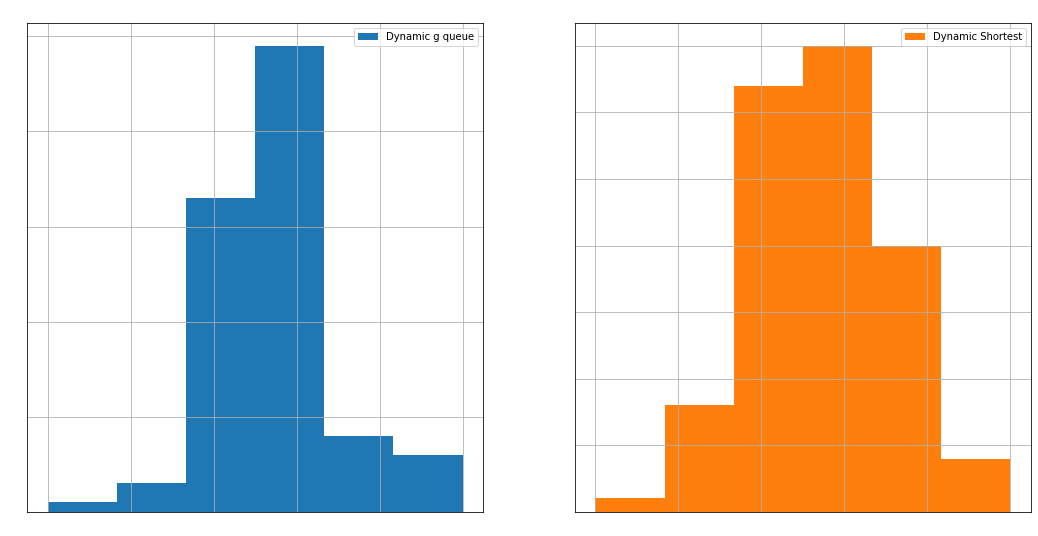

In [61]:
fig = plt.figure(figsize=(18, 9))
count = 1
colors = ["red", "tab:blue", "tab:orange"]


for key, value in server_dynamic.items():
    x_data, y_data = [item[0] for item in server_dynamic[key]], [item[1] for item in server_dynamic[key]]
    plt.subplot(1,2,count)
    plt.hist(y_data, bins=6, label = f"{key}", color = colors[count])
    count += 1

    plt.title("Server dynamic", color = 'w')
    plt.grid()
    plt.tick_params( colors='white')
    plt.legend(loc='best')

plt.show()



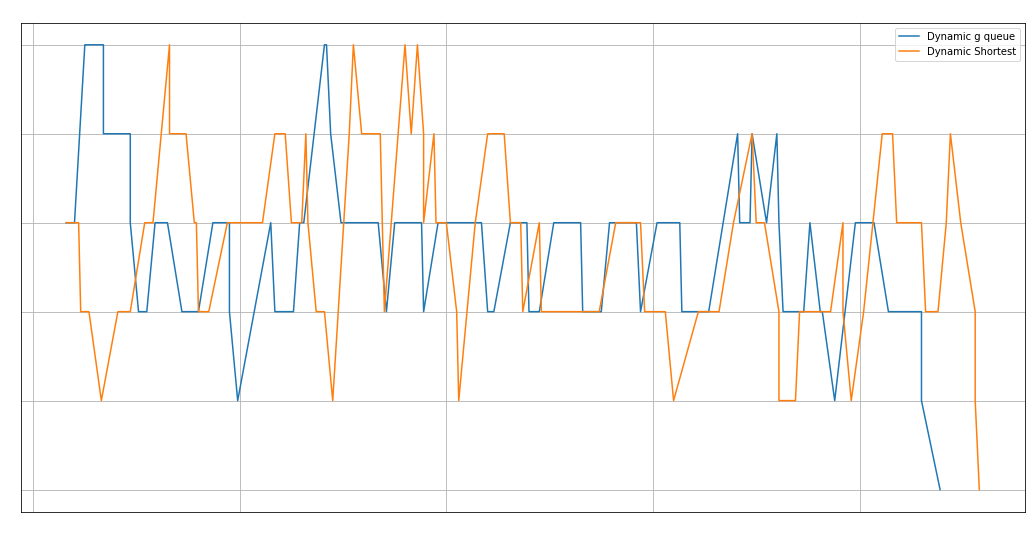

In [62]:
fig = plt.figure(figsize=(18, 9))

for key, value in server_dynamic.items():
    x_data, y_data = [item[0] for item in server_dynamic[key]], [item[1] for item in server_dynamic[key]]
    plt.plot(x_data, y_data, label = f"{key}")

plt.title("Server dynamic", color = 'w')
plt.grid()
plt.tick_params( colors='white')
plt.legend(loc='best')
plt.show()

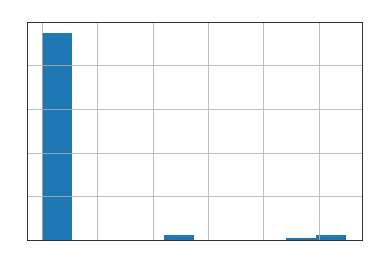

In [63]:
def DrawSampleHistogram(R, title, bins=None):
    fig = plt.figure()
    x = np.arange(len(R))
    plt.grid()
    if bins is None:
        plt.hist(R, range=None)
    else:
        plt.hist(R, bins=bins, range=None)

    plt.xticks(rotation='horizontal')
    plt.tick_params( colors='white')
    plt.title(title, color='white')
    plt.show()


DrawSampleHistogram([x.waitingTimeInQueue for x in DEVS.stats], "Waiting time in queue")